Confusing shapes DDPM

In [1]:
import torch
from model import *
from utils import *
from simple_ddpm_tasks import MANIFOLD_INFORMATION_DICTIONARY

import os, json

In [2]:
def load_model_from_args(args, model_path, device = 'cuda'):
    
    include_inputs = args.get('include_inputs', False)
    recurrence_hidden_layers = args['recurrence_hidden_layers']
    hidden_size = args['hidden_size']
    ultimate_time_steps = args['ultimate_num_timesteps']
    num_hidden_steps = args['num_timesteps']
    ultimate_sigma2 = args['ultimate_sigma2']
    baseline_sigma2 = args['baseline_sigma2']
    noise_schedule_power = args['noise_schedule_power']
    
    assert 1.0 == args['sigma2x_orthogonal_multiplier']

    manifold_name = args['manifold_name']
    manifold_information = MANIFOLD_INFORMATION_DICTIONARY[manifold_name]
    input_size = manifold_information[3]

    full_sigma2x_schedule_evo = (ultimate_sigma2 - baseline_sigma2) * 0.5 * (1.0 - torch.linspace(0, torch.pi, ultimate_time_steps).cos())
    full_sigma2x_schedule = baseline_sigma2 + full_sigma2x_schedule_evo**noise_schedule_power
    sigma2x_schedule = full_sigma2x_schedule[:num_hidden_steps]
    sigma2x_schedule = sigma2x_schedule.to(device=device)

    recurrence_model = RecurrenceModel(hidden_size, recurrence_hidden_layers, input_size)
    ddpm_model = UnrollingDDPMReverseProcess(
        hidden_size,
        recurrence_model,
        sigma2x_schedule,
        ultimate_time_steps,
    ).to(device=device)

    ddpm_model.load_state_dict(torch.load(model_path))

    return ddpm_model, manifold_information, sigma2x_schedule

In [3]:
base_path = '/homes/pr450/repos/research_projects/error_modelling_torus/results_link_sampler/ddpm_unrolling_circle_28_11_24/'

# unconditioned_model_path = os.path.join(base_path, 'unrolling_shapes_N8_RLQfT_0/state_T60.mdl')
# conditioned_model_path = os.path.join(base_path, 'unrolling_shapes_N8_RLQfT_0/state_T60_with_inputs.mdl')
# swapping_model_path = os.path.join(base_path, 'unrolling_shapes_uncertain_N8_RLQfT_0_0/state_T64_with_inputs.mdl')
## multiitem_model_path = os.path.join(base_path, 'unrolling_simple_multiitem_N8_YJ0y5_0/state_T64_with_inputs.mdl')
multiitem_model_path = os.path.join(base_path, 'unrolling_simple_multiitem_N8_Gk6Vi_0/state_T100.mdl')

# unconditioned_args_path = os.path.join(base_path, 'unrolling_shapes_N8_RLQfT_0/args_T60.json')
# conditioned_args_path = os.path.join(base_path, 'unrolling_shapes_N8_RLQfT_0/args_T60_with_inputs.json')
# swapping_args_path = os.path.join(base_path, 'unrolling_shapes_uncertain_N8_RLQfT_0_0/args_T64_with_inputs.json')
multiitem_args_path = os.path.join(base_path, 'unrolling_simple_multiitem_N8_Gk6Vi_0/args_T100.json')

# with open(unconditioned_args_path, 'r') as jf:
#     unconditioned_model_args = json.load(jf)
# with open(conditioned_args_path, 'r') as jf:
#     conditioned_model_args = json.load(jf)
# with open(swapping_args_path, 'r') as jf:
#     swapping_model_args = json.load(jf)
with open(multiitem_args_path, 'r') as jf:
    multiitem_model_args = json.load(jf)

# unconditioned_model, unconditioned_manifold_info, unconditioned_sigma2x_schedule = load_model_from_args(unconditioned_model_args, unconditioned_model_path)
# conditioned_model, conditioned_manifold_info, conditioned_sigma2x_schedule = load_model_from_args(conditioned_model_args, conditioned_model_path)
# swapping_model, swapping_manifold_info, swapping_sigma2x_schedule = load_model_from_args(swapping_model_args, swapping_model_path)
multiitem_model, multiitem_manifold_info, multiitem_sigma2x_schedule = load_model_from_args(multiitem_model_args, multiitem_model_path)

Run an example denoising trial

In [4]:
def run_batch(batch_size, ddpm_model, sigma2x_schedule, data_generation_function, include_inputs, turn_off_noise, capped_timesteps, *_, device = 'cuda'):

    y_samples, network_inputs, network_input_classes = data_generation_function(batch_size, include_inputs)  # [batch_size, 2]
    y_samples = y_samples.to(device=device, dtype = sigma2x_schedule.dtype)
    x_samples = run_forward_process(y_samples, sigma2x_schedule, 1.0, ddpm_model.linking_matrix, ddpm_model.rotation_matrix)   # [batch_size, T, hidden_size]

    if network_inputs is not None:
        network_inputs = network_inputs.to(device)

    with torch.no_grad():
        novel_samples, hidden_sample_history, novel_x0 = ddpm_model.generate_new_samples(
            base_samples = x_samples[:,-1],
            input_vector = network_inputs,
            turn_off_noise = turn_off_noise,
            capped_timesteps = capped_timesteps
        )

    return {
        "y_samples": y_samples.cpu().numpy(),
        "network_inputs": network_inputs.cpu().numpy(),
        "network_input_classes": network_input_classes.cpu().numpy(),
        "novel_samples": novel_samples.cpu().numpy(),
        "hidden_sample_history": hidden_sample_history,
        "novel_x0": novel_x0.cpu().numpy(),
        "base_samples": x_samples[:,-1].cpu().numpy(),
    }

Be sure that swaps in the final samples don't just arise from swaps in the noised version of the task

NameError: name 'swapping_model' is not defined

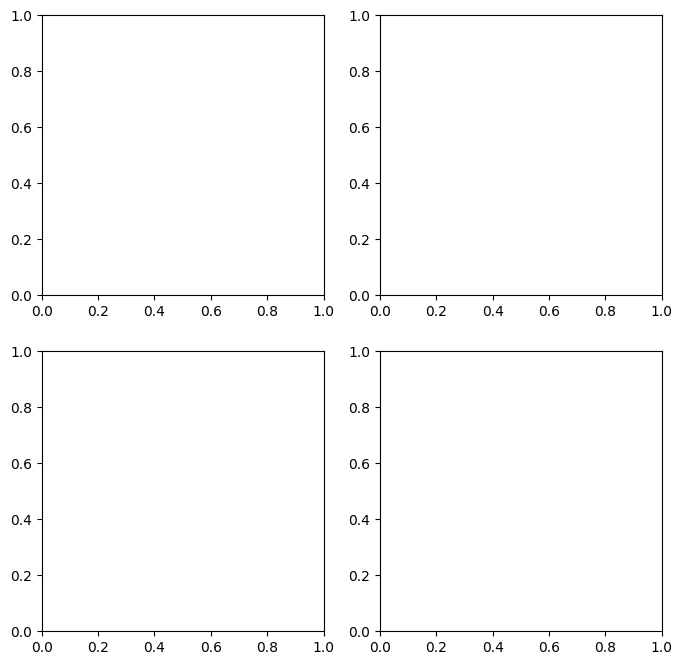

In [32]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize = (8, 8))

swapping_examples = run_batch(1024, swapping_model, swapping_sigma2x_schedule, swapping_manifold_info[0], True, False, None)

axes[0,0].set_title('GT')
scatter = axes[0,0].scatter(*swapping_examples['y_samples'].T, c = swapping_examples['network_input_classes'])
legend1 = axes[0,0].legend(*scatter.legend_elements(),loc="lower left", title="Classes")
axes[0,0].add_artist(legend1)
axes[0,0].plot(swapping_manifold_info[1], swapping_manifold_info[2], color = 'red')
axes[0,0].set_xlim(-2, 2)
axes[0,0].set_ylim(-2, 2)

axes[0,1].set_title('Samples')
new_samples = swapping_examples['novel_samples']
axes[0,1].scatter(*new_samples.T, c = swapping_examples['network_input_classes'])
axes[0,1].plot(swapping_manifold_info[1], swapping_manifold_info[2], color = 'red')
axes[0,1].set_xlim(-2, 2)
axes[0,1].set_ylim(-2, 2)


# Classify them into circle and square samples with a [1, -1] decision boundary
base_samples = swapping_examples['base_samples']
new_samples_decision_variable = new_samples.sum(-1)
fully_noised_samples_decision_variable = base_samples.sum(-1)
axes[1,0].scatter(fully_noised_samples_decision_variable, new_samples_decision_variable, s = 1)

In [33]:
swapping_examples_no_noise = run_batch(512, swapping_model, swapping_sigma2x_schedule, swapping_manifold_info[0], True, True, 5)

projected_sample_history_no_noise = (swapping_examples_no_noise['hidden_sample_history'] @ swapping_model.behvaiour_projection_matrix.cpu().numpy())
projected_x0_sample_no_noise = (swapping_examples_no_noise['novel_x0'] @ swapping_model.behvaiour_projection_matrix.cpu().numpy())

fig, axes = plt.subplots(1, figsize = (5, 5))

for pxsnm, pshnm in zip(projected_x0_sample_no_noise, projected_sample_history_no_noise):
    axes.plot(*pshnm.T, alpha = 0.2)
    axes.scatter(*pxsnm)

axes.plot(swapping_manifold_info[1], swapping_manifold_info[2], color = 'red', alpha = 0.5)
axes.set_xlim(-3, 3)
axes.set_ylim(-3, 3)

NameError: name 'swapping_model' is not defined

How does it do on a continuous task?

/scratch/anaconda3/envs/torch_v2/lib/python3.12/site-packages/torch/_tensor.py:1394: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1908.)
  return super().rename(names)
/homes/pr450/repos/research_projects/error_modelling_torus/sampling_ddpm/model.py:177: UserWarning: Tensor.T is deprecated on 0-D tensors. This function is the identity in these cases. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3645.)
  hidden_samples = next_means + (torch.randn_like(hidden_samples) * sigmaxt_tilde.T)


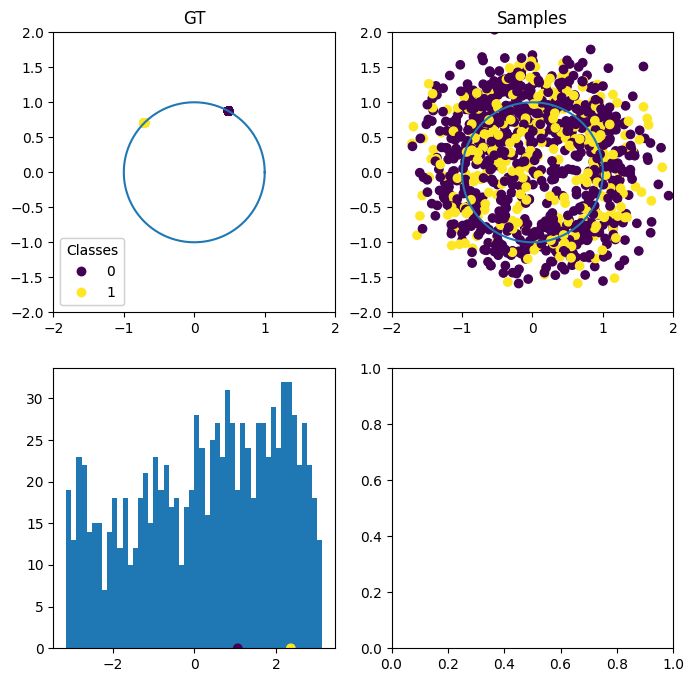

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize = (8, 8))

multiitem_examples = run_batch(1024, multiitem_model, multiitem_sigma2x_schedule, multiitem_manifold_info[0], True, False, None)

axes[0,0].set_title('GT')
scatter = axes[0,0].scatter(*multiitem_examples['y_samples'].T, c = multiitem_examples['network_input_classes'])
legend1 = axes[0,0].legend(*scatter.legend_elements(),loc="lower left", title="Classes")
axes[0,0].add_artist(legend1)
axes[0,0].plot(multiitem_manifold_info[1], multiitem_manifold_info[2])
axes[0,0].set_xlim(-2, 2)
axes[0,0].set_ylim(-2, 2)

axes[0,1].set_title('Samples')
new_samples = multiitem_examples['novel_samples']
axes[0,1].scatter(*new_samples.T, c = multiitem_examples['network_input_classes'])
axes[0,1].plot(multiitem_manifold_info[1], multiitem_manifold_info[2])
axes[0,1].set_xlim(-2, 2)
axes[0,1].set_ylim(-2, 2)

new_sample_angles = np.arctan2(new_samples[:,1], new_samples[:,0])
real_xys = multiitem_examples['network_inputs'][0]
real_angles = np.arctan2(real_xys[2:], real_xys[:2])
axes[1,0].hist(new_sample_angles, 50)
axes[1,0].scatter(real_angles, np.zeros_like(real_angles), c = range(len(real_angles)))

(-3.0, 3.0)

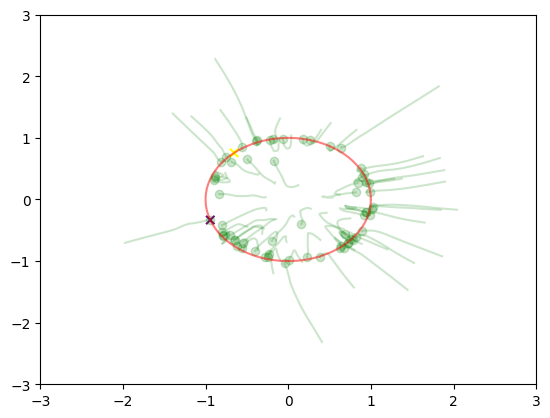

In [6]:
multiitem_examples_no_noise = run_batch(64, multiitem_model, multiitem_sigma2x_schedule, multiitem_manifold_info[0], True, True, 64)

projected_sample_history_no_noise = (multiitem_examples_no_noise['hidden_sample_history'].cpu().numpy() @ multiitem_model.behvaiour_projection_matrix.cpu().numpy())
projected_x0_sample_no_noise = (multiitem_examples_no_noise['novel_x0'] @ multiitem_model.behvaiour_projection_matrix.cpu().numpy())

real_xys = multiitem_examples_no_noise['network_inputs'][0]

plt.scatter(real_xys[:2], real_xys[2:], marker = 'x', c = ['purple', 'yellow'])

for pxsnm, pshnm in zip(projected_x0_sample_no_noise, projected_sample_history_no_noise):
    plt.plot(*pshnm.T, alpha = 0.2, color = 'green')
    plt.scatter(*pxsnm, alpha = 0.2, color = 'green')

plt.plot(multiitem_manifold_info[1], multiitem_manifold_info[2], color = 'red', alpha = 0.5)
plt.xlim(-3, 3)
plt.ylim(-3, 3)